In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Genesis Alpha"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2019-12-04"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 387 non-null    object        
 1   author             387 non-null    object        
 2   date               387 non-null    datetime64[us]
 3   start              387 non-null    datetime64[us]
 4   end                387 non-null    datetime64[us]
 5   platform_proposal  387 non-null    object        
 6   title              387 non-null    object        
 7   description        387 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 24.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        2203 non-null   object        
 1   proposal  2203 non-null   object

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0x144c4e5027b69f7798b2b162d924bcae5c149f15,5542b602-fae5-5894-8139-1bbc3f6fa3f9,2019-04-10 19:38:39,1
1,0xf3215bf9ad166213e2588baf81d7e932fda99d9e,5542b602-fae5-5894-8139-1bbc3f6fa3f9,2019-04-10 21:25:42,1
2,0x24597c5c68687e816ffc0c69e064cb70bb62a9cd,5542b602-fae5-5894-8139-1bbc3f6fa3f9,2019-04-10 22:06:20,1
3,0x6ac0a885ed84f4a2d062c60fb7daaf504fc8c47f,5542b602-fae5-5894-8139-1bbc3f6fa3f9,2019-04-11 07:24:41,1
4,0xc4d9d1a93068d311ab18e988244123430eb4f1cd,c56c81ad-7bf9-5aa7-bbbe-b643317cfc6d,2019-04-11 08:23:09,1
...,...,...,...,...
2198,0x0ebbda43014a6e6c32657a8db79376738d549b2f,c6ee2096-b2dc-51ee-bc1f-b96653e2c0bf,2020-04-29 05:44:45,1
2199,0x0ebbda43014a6e6c32657a8db79376738d549b2f,052958a4-180c-54ad-a4ba-dfc0c210dd3b,2020-05-02 06:32:56,1
2200,0x4171160db0e7e2c75a4973b7523b437c010dd9d4,c6ee2096-b2dc-51ee-bc1f-b96653e2c0bf,2020-05-07 14:36:22,1
2201,0x00234af289964cc53cae46452ddac6253fc3ec3a,d5234f86-22bc-5f5e-9b91-eb91719d4bfb,2020-12-12 18:37:20,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2019-10-02 00:00:00'),
 Timestamp('2019-10-09 00:00:00'),
 Timestamp('2019-10-16 00:00:00'),
 Timestamp('2019-10-23 00:00:00'),
 Timestamp('2019-10-30 00:00:00'),
 Timestamp('2019-11-06 00:00:00'),
 Timestamp('2019-11-13 00:00:00'),
 Timestamp('2019-11-20 00:00:00'),
 Timestamp('2019-11-27 00:00:00'),
 Timestamp('2019-12-04 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/Genesis Alpha/hparams-pln-similarity_7d_normalize.pkl with 280 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2019-10-02,all-mpnet-base-v2,7d,0.226776,0.001335,10,0.100000,0.066667,0.060000,0.110000,...,0.393333,1.000000,1.0,0.200000,0.225000,0.225000,0.225000,0.225000,0.225000,0.129372
1,2019-10-02,all-mpnet-base-v2,14d,0.077563,0.001327,16,0.125000,0.041667,0.062500,0.137500,...,0.646875,0.968750,1.0,0.225000,0.225000,0.225000,0.225000,0.225000,0.225000,0.129053
2,2019-10-02,all-mpnet-base-v2,21d,0.228514,0.001337,18,0.111111,0.055556,0.044444,0.133333,...,0.630556,0.972222,1.0,0.225000,0.316667,0.316667,0.316667,0.316667,0.316667,0.129782
3,2019-10-02,all-mpnet-base-v2,30d,0.078502,0.001453,20,0.100000,0.050000,0.060000,0.105000,...,0.442500,0.975000,1.0,0.225000,0.261111,0.261111,0.261111,0.261111,0.261111,0.135301
4,2019-10-02,all-mpnet-base-v2,60d,0.228406,0.001461,27,0.074074,0.086420,0.066667,0.092593,...,0.435802,0.925926,1.0,0.225000,0.356667,0.356667,0.356667,0.356667,0.356667,0.136218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2019-12-04,all-MiniLM-L6-v2,21d,0.218425,0.001294,30,0.100000,0.144444,0.166667,0.180000,...,1.000000,1.000000,1.0,0.714286,0.608844,0.629252,0.670068,0.670068,0.670068,0.130085
276,2019-12-04,all-MiniLM-L6-v2,30d,0.068457,0.001312,32,0.093750,0.135417,0.175000,0.181250,...,1.000000,1.000000,1.0,0.492063,0.540816,0.581633,0.622449,0.622449,0.622449,0.130468
277,2019-12-04,all-MiniLM-L6-v2,60d,0.222154,0.001372,34,0.058824,0.137255,0.152941,0.176471,...,1.000000,1.000000,1.0,0.238095,0.432540,0.456349,0.503968,0.503968,0.503968,0.135203
278,2019-12-04,all-MiniLM-L6-v2,90d,0.225718,0.001393,34,0.058824,0.137255,0.152941,0.176471,...,1.000000,1.000000,1.0,0.238095,0.432540,0.456349,0.503968,0.503968,0.503968,0.132380


<Axes: xlabel='window_size', ylabel='map@10'>

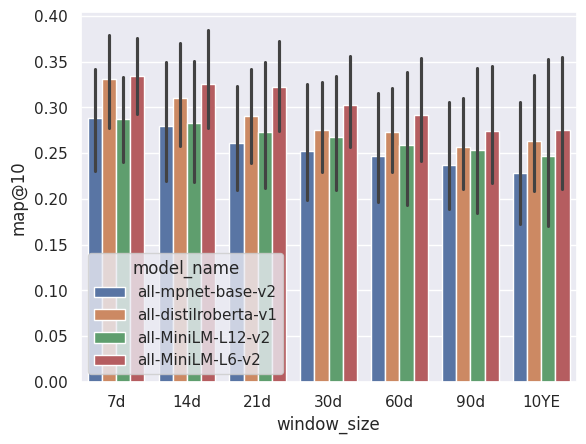

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
7d          all-distilroberta-v1    0.182182     0.191708      0.169943   
            all-MiniLM-L6-v2        0.150084     0.185356      0.176751   
14d         all-MiniLM-L6-v2        0.151700     0.178864      0.173336   
21d         all-MiniLM-L6-v2        0.134316     0.187048      0.168883   
14d         all-distilroberta-v1    0.132350     0.183299      0.166859   
30d         all-MiniLM-L6-v2        0.166896     0.181261      0.167474   
7d          all-mpnet-base-v2       0.112907     0.171007      0.170074   
21d         all-distilroberta-v1    0.167433     0.184991      0.160443   
60d         all-MiniLM-L6-v2        0.153455     0.172079      0.161184   
7d          all-MiniLM-L12-v2       0.149706     0.160997      0.172740   
14d         all-MiniLM-L12-v2       0.166631     0.164498      0.167819   
            all-mpnet-base-v2       0.197437     0.167208      0.161758   
21d         all-MiniLM-L12-v2       0.167695     0.164908      0.160405   
30d         all-distilroberta-v1    0.166823     0.181836      0.161971   
10YE        all-MiniLM-L6-v2        0.164067     0.154367      0.155618   
30d         all-MiniLM-L12-v2       0.152834     0.163108      0.162295   
90d         all-MiniLM-L6-v2        0.188497     0.165427      0.156015   
60d         all-distilroberta-v1    0.201348     0.172928      0.156307   
            all-MiniLM-L12-v2       0.154615     0.154779      0.155347   
10YE        all-distilroberta-v1    0.164385     0.148386      0.148915   
21d         all-mpnet-base-v2       0.164126     0.161848      0.156754   
90d         all-MiniLM-L12-v2       0.172316     0.155643      0.151781   
30d         all-mpnet-base-v2       0.166730     0.156167      0.154194   
90d         all-distilroberta-v1    0.187712     0.160397      0.151151   
10YE        all-MiniLM-L12-v2       0.180794     0.139342      0.144739   
60d         all-mpnet-base-v2       0.185703     0.143319      0.152597   
90d         all-mpnet-base-v2       0.153980     0.138905      0.146118   
10YE        all-mpnet-base-v2       0.196717     0.133725      0.141880   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
7d          all-distilroberta-v1       0.021315  0.189121  0.256504  0.297523   
            all-MiniLM-L6-v2           0.021315  0.186402  0.265541  0.298741   
14d         all-MiniLM-L6-v2           0.020162  0.222521  0.330428  0.363396   
21d         all-MiniLM-L6-v2           0.019384  0.261886  0.377356  0.409929   
14d         all-distilroberta-v1       0.020162  0.218727  0.311989  0.353780   
30d         all-MiniLM-L6-v2           0.019025  0.258421  0.388843  0.421102   
7d          all-mpnet-base-v2          0.021315  0.168738  0.248448  0.286574   
21d         all-distilroberta-v1       0.019384  0.242788  0.351884  0.395094   
60d         all-MiniLM-L6-v2           0.018596  0.262834  0.405691  0.445541   
7d          all-MiniLM-L12-v2          0.021315  0.157713  0.250893  0.284112   
14d         all-MiniLM-L12-v2          0.020162  0.198491  0.308720  0.347272   
            all-mpnet-base-v2          0.020162  0.198949  0.296718  0.343533   
21d         all-MiniLM-L12-v2          0.019384  0.224139  0.345101  0.388150   
30d         all-distilroberta-v1       0.019025  0.241302  0.365263  0.403980   
10YE        all-MiniLM-L6-v2           0.017973  0.265603  0.442555  0.484056   
30d         all-MiniLM-L12-v2          0.019025  0.231223  0.365480  0.403827   
90d         all-MiniLM-L6-v2           0.018317  0.258230  0.412620  0.458840   
60d         all-distilroberta-v1       0.018596  0.253950  0.387798  0.432847   
            all-MiniLM-L12-v2          0.018596  0.233768  0.382834  0.428382   
10YE        all-distilroberta-v1       0.017973  0.254467  0.423216  0.477256   
2

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Genesis Alpha/models/plnsim-best-avg_7d_normalize.parquet


/tmp/ipykernel_3813416/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2019-10-02,7d,all-distilroberta-v1,0.228433,0.001254,10,0.200000,0.133333,0.120000,0.130000,0.166667,0.025000,0.066667,...,0.510000,1.00000,1.0,0.500000,0.400000,0.400000,0.400000,0.400000,0.400000,0.126895
2019-10-09,7d,all-distilroberta-v1,0.230400,0.001252,13,0.153846,0.102564,0.092308,0.123077,0.082051,0.012308,0.083333,...,1.000000,1.00000,1.0,0.750000,0.666667,0.666667,0.666667,0.666667,0.666667,0.124939
2019-10-16,7d,all-distilroberta-v1,0.079111,0.001238,6,0.166667,0.333333,0.200000,0.166667,0.111111,0.016667,0.040000,...,1.000000,1.00000,1.0,0.500000,0.750000,0.750000,0.750000,0.750000,0.750000,0.124378
2019-10-23,7d,all-distilroberta-v1,0.231343,0.001329,9,0.333333,0.296296,0.244444,0.200000,0.133333,0.020000,0.142857,...,1.000000,1.00000,1.0,0.472222,0.666667,0.777778,0.777778,0.777778,0.777778,0.125915
2019-10-30,7d,all-distilroberta-v1,0.231785,0.001279,8,0.500000,0.250000,0.200000,0.162500,0.158333,0.027500,0.200000,...,0.512500,0.83125,1.0,0.462500,0.490000,0.510000,0.570000,0.570000,0.570000,0.127591
2019-11-06,7d,all-distilroberta-v1,0.236339,0.001451,20,0.150000,0.250000,0.300000,0.235000,0.173333,0.029000,0.120000,...,0.830833,0.89250,1.0,0.288889,0.354167,0.477083,0.477083,0.477083,0.477083,0.135592
2019-11-13,7d,all-distilroberta-v1,0.082912,0.001487,17,0.235294,0.117647,0.094118,0.082353,0.094118,0.020588,0.153846,...,0.407843,0.62549,1.0,0.466667,0.516667,0.516667,0.558333,0.558333,0.558333,0.136350
2019-11-20,7d,all-distilroberta-v1,0.235592,0.001283,13,0.307692,0.205128,0.153846,0.107692,0.117949,0.017692,0.235294,...,0.500000,1.00000,1.0,0.562500,0.750000,0.750000,0.750000,0.750000,0.750000,0.127400
2019-11-27,7d,all-distilroberta-v1,0.231924,0.001283,14,0.357143,0.357143,0.271429,0.221429,0.166667,0.025000,0.277778,...,0.857143,1.00000,1.0,0.366667,0.447917,0.489583,0.489583,0.489583,0.489583,0.127097


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/Genesis Alpha/models/plnsim-best-val_7d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2019-10-02,all-MiniLM-L6-v2,7d,0.064249,0.160000,0.180000,0.025000,0.092918,0.150992,0.178455,0.181667,0.271190,0.324151,0.331667,0.793333,1.0,0.396667,0.396667,0.396667
2019-10-09,all-mpnet-base-v2,7d,0.078013,0.092308,0.123077,0.012308,0.151289,0.273210,0.273210,0.224359,0.337454,0.337454,0.384615,1.000000,1.0,0.666667,0.666667,0.666667
2019-10-16,all-distilroberta-v1,7d,0.079111,0.200000,0.166667,0.016667,0.105237,0.141428,0.141428,0.375000,0.448578,0.448578,0.583333,1.000000,1.0,0.750000,0.750000,0.750000
2019-10-23,all-distilroberta-v1,14d,0.080689,0.240000,0.190000,0.020000,0.245935,0.312297,0.319966,0.457500,0.533889,0.541581,0.541667,0.950000,1.0,0.733333,0.766667,0.766667
2019-10-30,all-mpnet-base-v2,7d,0.080124,0.150000,0.150000,0.027500,0.158491,0.183171,0.247805,0.331250,0.369678,0.446876,0.306250,0.481250,1.0,0.490000,0.570000,0.570000
2019-11-06,all-MiniLM-L6-v2,60d,0.072061,0.330435,0.230435,0.027826,0.376858,0.473893,0.532621,0.296630,0.370811,0.408283,0.560145,0.812319,1.0,0.497436,0.497436,0.497436
2019-11-13,all-MiniLM-L6-v2,30d,0.070693,0.176000,0.140000,0.020000,0.269428,0.362611,0.459121,0.206578,0.259475,0.296778,0.377333,0.646667,1.0,0.460000,0.476667,0.476667
2019-11-20,all-MiniLM-L12-v2,7d,0.213165,0.138462,0.161538,0.017692,0.254816,0.402907,0.425009,0.282051,0.380975,0.393796,0.365385,0.903846,1.0,0.625000,0.625000,0.625000
2019-11-27,all-MiniLM-L12-v2,10YE,0.083518,0.300000,0.216667,0.022222,0.657221,0.760800,0.770006,0.586204,0.654745,0.659375,0.712963,0.972222,1.0,0.743590,0.743590,0.743590


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,0.104005,0.195387,0.173838,0.020721,0.253675,0.344815,0.373446,0.314342,0.394285,0.417292,0.460463,0.855964,1.0,0.599194,0.616276,0.616276
std,0.059205,0.074216,0.033111,0.004965,0.165530,0.184514,0.186584,0.128934,0.122150,0.113706,0.132424,0.175415,0.0,0.129262,0.127454,0.127454
min,0.064249,0.092308,0.123077,0.012308,0.092918,0.141428,0.141428,0.181667,0.259475,0.296778,0.306250,0.481250,1.0,0.396667,0.396667,0.396667
25%,0.073549,0.152500,0.152885,0.017769,0.153089,0.205681,0.254157,0.211023,0.321403,0.327477,0.368372,0.798080,1.0,0.491859,0.515577,0.515577
50%,0.079618,0.171333,0.173333,0.020000,0.235245,0.337454,0.353400,0.289341,0.370244,0.401039,0.412943,0.926923,1.0,0.627126,0.645833,0.645833
75%,0.082811,0.230000,0.187500,0.024306,0.265775,0.398889,0.450593,0.364062,0.431677,0.448153,0.555525,0.993056,1.0,0.716667,0.725209,0.725209
max,0.218425,0.330435,0.230435,0.027826,0.657221,0.760800,0.770006,0.586204,0.654745,0.659375,0.712963,1.000000,1.0,0.750000,0.766667,0.766667


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Genesis Alpha/models/plnsim-best-test_7d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2019-10-09,all-MiniLM-L6-v2,7d,0.064978,0.107692,0.123077,0.012308,0.167408,0.270716,0.270716,0.239744,0.333150,0.333150,0.461538,1.000000,1.0,0.666667,0.666667,0.666667
2019-10-16,all-mpnet-base-v2,7d,0.077957,0.166667,0.166667,0.016667,0.073774,0.120492,0.120492,0.236111,0.332341,0.332341,0.500000,1.000000,1.0,0.500000,0.500000,0.500000
2019-10-23,all-distilroberta-v1,7d,0.231343,0.244444,0.200000,0.020000,0.186602,0.256368,0.256368,0.387037,0.457407,0.457407,0.509259,1.000000,1.0,0.777778,0.777778,0.777778
2019-10-30,all-distilroberta-v1,14d,0.082272,0.200000,0.154545,0.024545,0.196029,0.233475,0.300103,0.297475,0.310180,0.373232,0.346970,0.615152,1.0,0.563333,0.603333,0.603333
2019-11-06,all-mpnet-base-v2,7d,0.080751,0.210000,0.190000,0.029000,0.177577,0.291489,0.384317,0.132722,0.208327,0.270745,0.318333,0.665000,1.0,0.409524,0.409524,0.409524
2019-11-13,all-MiniLM-L6-v2,60d,0.218616,0.184000,0.144000,0.020000,0.273225,0.353163,0.457465,0.207356,0.257038,0.296280,0.390667,0.603333,1.0,0.425758,0.440909,0.440909
2019-11-20,all-MiniLM-L6-v2,30d,0.214124,0.150000,0.150000,0.016250,0.277378,0.458326,0.489279,0.259896,0.352765,0.362438,0.312500,0.875000,1.0,0.800000,0.800000,0.800000
2019-11-27,all-MiniLM-L12-v2,7d,0.217294,0.228571,0.228571,0.025000,0.296400,0.437988,0.466807,0.284048,0.399993,0.419473,0.434524,0.886905,1.0,0.479167,0.479167,0.479167
2019-12-04,all-MiniLM-L12-v2,10YE,0.229709,0.126316,0.168421,0.016842,0.193053,0.443835,0.443835,0.134035,0.256454,0.256454,0.256266,1.000000,1.0,0.425595,0.443452,0.443452


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000
mean,0.157449,0.179743,0.169476,0.020068,0.204605,0.318428,0.354376,0.242047,0.323073,0.344613,0.392229,0.849488,1.0,0.560869,0.568981,0.568981
std,0.077153,0.046119,0.032129,0.005255,0.069095,0.114044,0.124809,0.079875,0.076781,0.066436,0.089622,0.174000,0.0,0.152181,0.149206,0.149206
min,0.064978,0.107692,0.123077,0.012308,0.073774,0.120492,0.120492,0.132722,0.208327,0.256454,0.256266,0.603333,1.0,0.409524,0.409524,0.409524
25%,0.080751,0.150000,0.150000,0.016667,0.177577,0.256368,0.270716,0.207356,0.257038,0.296280,0.318333,0.665000,1.0,0.425758,0.443452,0.443452
50%,0.214124,0.184000,0.166667,0.020000,0.193053,0.291489,0.384317,0.239744,0.332341,0.333150,0.390667,0.886905,1.0,0.500000,0.500000,0.500000
75%,0.218616,0.210000,0.190000,0.024545,0.273225,0.437988,0.457465,0.284048,0.352765,0.373232,0.461538,1.000000,1.0,0.666667,0.666667,0.666667
max,0.231343,0.244444,0.228571,0.029000,0.296400,0.458326,0.489279,0.387037,0.457407,0.457407,0.509259,1.000000,1.0,0.800000,0.800000,0.800000
